In [1]:
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
from pandarus import *
from rasterio import plot as rp
import geopandas as gpd
import json
import os
import pandas as pd
import rasterio

In [3]:
ls ../tests/data/

DEM.tif                  lines.geojson            test_countries.gpkg
big-grid.geojson         point.geojson            test_provinces.gpkg
duplicates.geojson       points.geojson           test_raster_cfs.tif
grid.geojson             range.tif                test_raster_loading.tif
inpt.tif                 raster_cfs_32bit.tif     testfile.hash
invalid.txt              square.geojson


In [12]:
provinces = gpd.read_file("../tests/data/test_provinces.gpkg")
big_grid = gpd.read_file("../tests/data/big-grid.geojson")
grid = gpd.read_file("../tests/data/grid.geojson")
range_fp = os.path.join('..', 'tests', 'data', 'range.tif')
grid_fp = os.path.join('..', 'tests', 'data', 'grid.geojson')

# Match two vector datasets

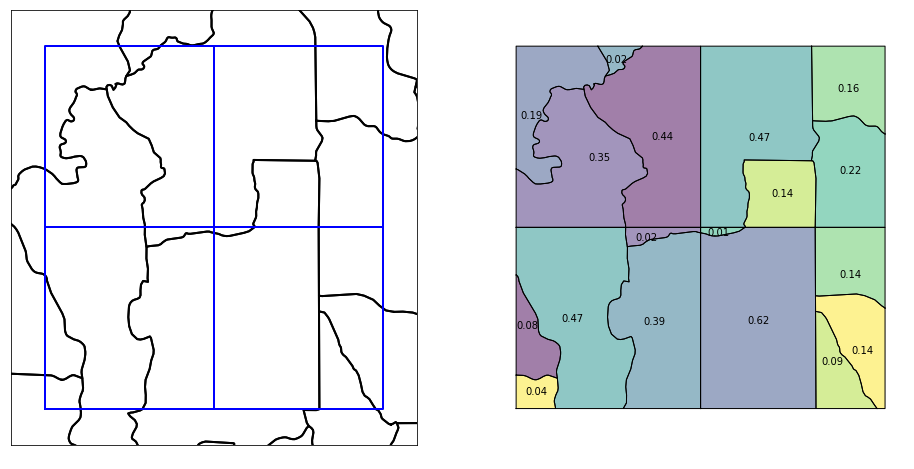

In [7]:
figure, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16, 8))
provinces.plot(color='white', figsize=(6, 6), ax=ax1, linewidth=2)
big_grid.plot(ax=ax1, alpha=0.5, facecolor='None', edgecolor='blue', linewidth=2)
ax1.set_xlim(-0.2, 2.2)
ax1.set_ylim(6.8, 9.2)
ax1.set_xticks([])
ax1.set_yticks([])

spatial_result, _ = Pandarus(
    "../tests/data/big-grid.geojson", 
    "../tests/data/test_provinces.gpkg", 
    {'field': 'name'}, 
    {'field': 'name'}
).intersect()

intersection = gpd.read_file(spatial_result)

intersection.plot(ax=ax2, alpha=0.5)
intersection.apply(
    lambda x: ax2.annotate(
        s="{:2.2f}".format(x['measure']), 
        xy=x.geometry.representative_point().coords[0], 
        ha='center',
        va='center'), 
    axis=1
)
ax2.axis('off')
plt.savefig("images/two-vectors.png", bbox_inches='tight', transparent=True)

# Calculate areas

In [8]:
json_data = json.load(open(Pandarus(
    "../tests/data/test_provinces.gpkg", 
    from_metadata={'field': 'name'}, 
).areas(compress=False)))

In [9]:
merged = provinces.merge(pd.DataFrame(json_data['data'], columns=['name', 'value']))

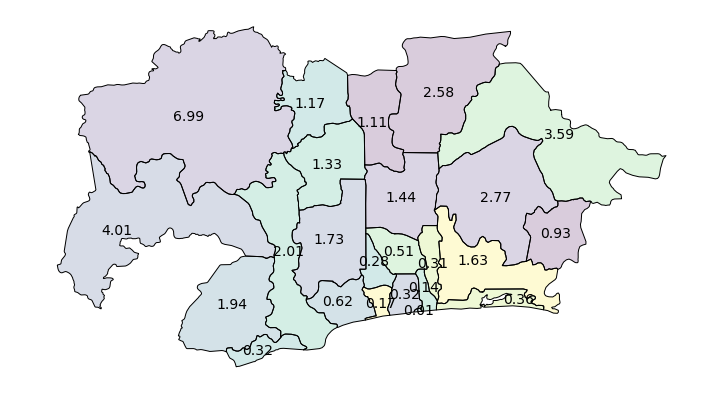

In [10]:
ax = merged.plot(figsize=(12, 8), alpha=0.2)
merged.apply(lambda x: ax.annotate(
    s="{:2.2f}".format(x['value'] / 1e10),
    xy=x.geometry.representative_point().coords[0], 
    ha='center',
    va='center',
    size=14
), axis=1)

ax.axis('off')
plt.savefig("images/areas.png", bbox_inches='tight', transparent=True)
pass

# Raster statistics

In [15]:
json_data = json.load(open(Pandarus(
    grid_fp, 
    from_metadata={'field': 'name'}, 
).rasterstats(range_fp, compressed=False)))

In [23]:
merged = grid.merge(pd.DataFrame([(x, y['mean']) for x, y in json_data['data']], columns=['name', 'value']))

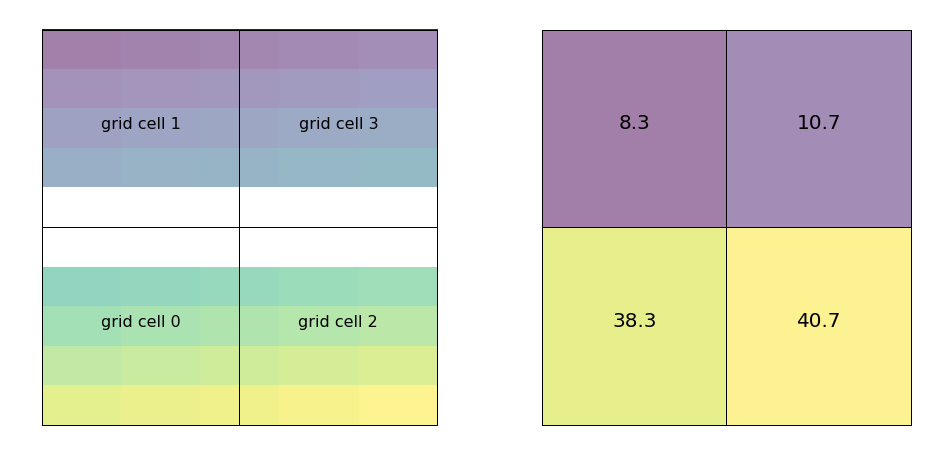

In [26]:
figure, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16, 8))
grid.plot(color='white', ax=ax1)
grid.apply(lambda x: ax1.annotate(
    s=x['name'], 
    xy=x.geometry.representative_point().coords[0], 
    ha='center',
    size=16
), axis=1)

with rasterio.open(range_fp) as raster:
    img = rp.show(raster, ax=ax1)

ax1.axis('off')

ax = merged.plot(column='value', figsize=(6, 6), ax=ax2)
merged.apply(lambda x: ax2.annotate(
    s="{:2.1f}".format(x['value']),
    xy=x.geometry.representative_point().coords[0], 
    ha='center',
    size=20
), axis=1)    
    
ax2.axis('off')
plt.savefig("images/rasterstats.png", bbox_inches='tight', transparent=True)
pass